## Is it AI?

In [1]:
!pip install -U ddgs 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.1 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install --upgrade jupyter_client 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: jupyter_client
    Found existing installation: jupyter_client 7.4.9
    Uninstalling jupyter_client-7.4.9:
      Successfully uninstalled jupyter_client-7.4.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.8.0 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.8.0 which is incompatible.


In [4]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [5]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of human faces and AI-generated faces

In [6]:
from ddgs import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [64]:
urls = search_images('ai generated face', max_images=1)
urls[0]

'https://media.theresanaiforthat.com/realistic-human-face-generator@2881090.png?width=1000'

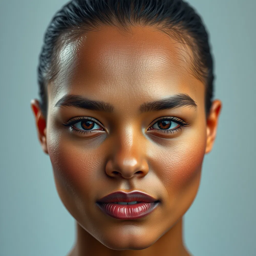

In [40]:
from fastdownload import download_url
dest = 'ai_face.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching images for human faces:

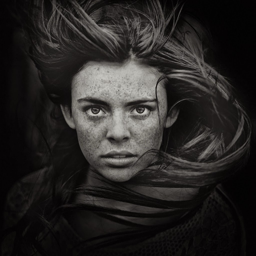

In [58]:
download_url(search_images('a human being face', max_images=1)[0], 'human_face.jpg', show_progress=False)
Image.open('human_face.jpg').to_thumb(256,256)

In [59]:
searches = 'human','ai'
path = Path('ai_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train the model

Checking for failure in training

In [60]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

DataBlock which stores data for image classification

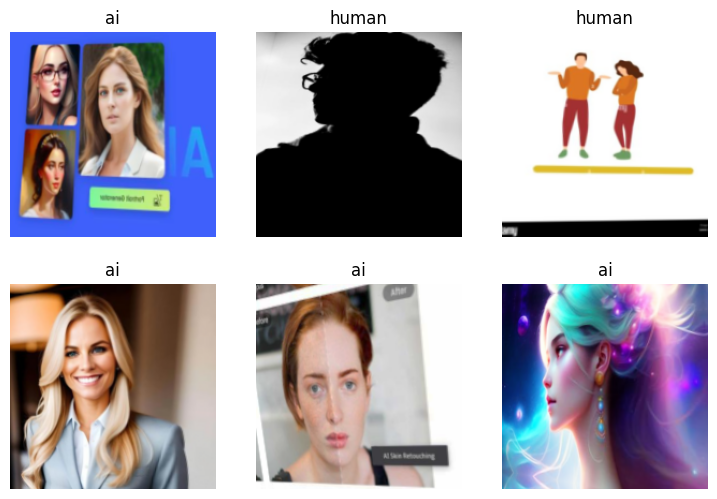

In [63]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

We will use **resnet18** model

In [34]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.615248,1.267246,0.468750,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.641489,1.055210,0.343750,00:18
1,0.458157,0.756720,0.312500,00:18
2,0.319924,0.693780,0.187500,00:17


## Step 3: Using the model

Let's see what our model thinks about that bird we downloaded at the start:

In [38]:
is_ai, idx, probs = learn.predict(PILImage.create('human_face.jpg'))
print(probs)
print(learn.dls.vocab)
print(f"This is a: {is_ai}.")
print(f"Confidence: {probs[idx]:.4f}")

tensor([0.0092, 0.9908])
['ai', 'human']
This is a: human.
Confidence: 0.9908
